## 필요한 라이브러리 install

In [42]:
 !pip install torch torchvision torchaudio tensorflow albumentations timm opencv-python matplotlib kagglehub pandas scikit-learn seaborn

## GPU 환경 설정

In [1]:
import tensorflow as tf

# GPU 0만 사용
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # GPU 0만 사용
        tf.config.experimental.set_memory_growth(gpus[0], True)  # 메모리 동적 할당
    except RuntimeError as e:
        print(e)

# TensorFlow에서 사용할 장치 확인
print(tf.config.experimental.list_logical_devices('GPU'))


2025-02-24 00:54:07.407843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 00:54:07.422092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 00:54:07.426408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 00:54:07.439152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-24 00:54:08.168953: W tensorflow/compiler/tf2

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2025-02-24 00:54:09.615536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8290 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["CUDNN_PATH"] = "/usr/local/cuda"
# os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64"

# import tensorflow as tf
# print(tf.sysconfig.get_build_info()["cudnn_version"])  # 9.1.0 출력 확인

In [8]:
import tensorflow as tf
print(tf.sysconfig.get_build_info()["cudnn_version"])

8


## 데이터셋 합치기 + 불러오기

In [1]:
# 캐글 데이터셋 다운로드 라이브러리
import kagglehub

In [2]:
## face_data

# Download latest version
path1 = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")

print("Path to dataset files:", path1)

Path to dataset files: /home/jangminoh_2/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2


In [3]:
#CIFAKE Midjourney 변형 데이터셋

# Download latest version
path2 = kagglehub.dataset_download("mariammarioma/midjourney-cifake-inspired")

print("Path to dataset files:", path2)

Path to dataset files: /home/jangminoh_2/.cache/kagglehub/datasets/mariammarioma/midjourney-cifake-inspired/versions/1


In [4]:
#CIFAKE 데이터셋

# Download latest version
path3 = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path3)

Path to dataset files: /home/jangminoh_2/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [5]:
## Dalle, midjourney

path4 = kagglehub.dataset_download("superpotato9/dalle-recognition-dataset")

print("Path to dataset files:", path4)

Path to dataset files: /home/jangminoh_2/.cache/kagglehub/datasets/superpotato9/dalle-recognition-dataset/versions/7


### 데이터셋 경로 설정

In [8]:
#face 데이터셋 경로 설정 #70,000 real & 70,000 fake
face_train_directory = "/home/jangminoh_2/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train"
face_test_directory = "/home/jangminoh_2/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test"

#CIFAKE #60,000 real & 60,000 fake
cifake_train_directory = "/home/jangminoh_2/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train"
cifake_test_directory = "/home/jangminoh_2/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/test"

#CIFAKE Midjourney #2,000 real & 2,000 fake
cifake_mid_train_directory = "/home/jangminoh_2/.cache/kagglehub/datasets/mariammarioma/midjourney-cifake-inspired/versions/1/Midjourney/train"
cifake_mid_test_directory = "/home/jangminoh_2/.cache/kagglehub/datasets/mariammarioma/midjourney-cifake-inspired/versions/1/Midjourney/test"
cifake_mid_val_directory = "/home/jangminoh_2/.cache/kagglehub/datasets/mariammarioma/midjourney-cifake-inspired/versions/1/Midjourney/valid"

## dalle + midjourney #17855 & Real Images: 3780
fake_dir = "/home/jangminoh_2/.cache/kagglehub/datasets/superpotato9/dalle-recognition-dataset/versions/7/fakeV2/fake-v2"
real_dir = "/home/jangminoh_2/.cache/kagglehub/datasets/superpotato9/dalle-recognition-dataset/versions/7/real"

In [18]:
import os
# 디렉토리 리스트로 구성
directories = [
    face_train_directory,
    face_test_directory,
    cifake_train_directory,
    cifake_test_directory,
    cifake_mid_train_directory,
    cifake_mid_test_directory,
    cifake_mid_val_directory,
    fake_dir,
    real_dir
]

# 각 디렉토리에서 real과 fake 폴더의 구조 출력
for directory in directories:
    print(f"Checking directory structure for: {directory}")

    if os.path.exists(directory):
        for subdir in os.listdir(directory):
            subdir_path = os.path.join(directory, subdir)
            if os.path.isdir(subdir_path):
                print(f"  {subdir_path} exists as a directory")
    else:
        print(f"  {directory} does not exist")
    print("\n")

Checking directory structure for: /home/jangminoh_2/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train
  /home/jangminoh_2/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train/fake exists as a directory
  /home/jangminoh_2/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/train/real exists as a directory


Checking directory structure for: /home/jangminoh_2/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test
  /home/jangminoh_2/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/fake exists as a directory
  /home/jangminoh_2/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake/test/real exists as a directory


Checking directory structure for: /home/jangminoh_2/.cache/kagglehub/datasets/birdy654/cifake-real-an



Checking directory structure for: /home/jangminoh_2/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train/REAL




In [19]:
import os
import pandas as pd
from IPython.display import display

# ✅ 이미지 확장자 목록
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp", ".gif")

# ✅ 디렉토리 매핑 (fake/real 추가)
directories_with_labels = {
    "GAN_FaceData_train/fake": f"{face_train_directory}/fake",
    "GAN_FaceData_train/real": f"{face_train_directory}/real",
    "GAN_FaceData_test/fake": f"{face_test_directory}/fake",
    "GAN_FaceData_test/real": f"{face_test_directory}/real",
    "Diffusion_train/fake": f"{cifake_train_directory}/FAKE",
    "Diffusion_train/real": f"{cifake_train_directory}/REAL",
    "Diffusion_test/fake": f"{cifake_test_directory}/FAKE",
    "Diffusion_test/real": f"{cifake_test_directory}/REAL",    
    "Midjourney_train/fake": f"{cifake_mid_train_directory}/FAKE",
    "Midjourney_train/real": f"{cifake_mid_train_directory}/REAL",
    "Midjourney_test/fake": f"{cifake_mid_test_directory}/FAKE",
    "Midjourney_test/real": f"{cifake_mid_test_directory}/REAL",
    "Midjourney_val/fake": f"{cifake_mid_val_directory}/FAKE",
    "Midjourney_val/real": f"{cifake_mid_val_directory}/REAL", 
    "Midjourney&Dalle/fake":fake_dir,
    "Midjourney&Dalle/real":real_dir   
    
}

# ✅ 각 디렉토리 내 이미지 개수 확인
image_counts = {}

for label, directory in directories_with_labels.items():
    if os.path.exists(directory) and os.path.isdir(directory):
        image_counts[label] = sum(
            1 for f in os.listdir(directory) if f.lower().endswith(image_extensions)
        )
    else:
        image_counts[label] = "Directory not found"

# ✅ 결과 출력
df = pd.DataFrame(list(image_counts.items()), columns=["Directory", "Image Count"])

# Jupyter Notebook에서 보기 좋게 출력
display(df)


,Directory,Image Count
0,GAN_FaceData_train/fake,50000
1,GAN_FaceData_train/real,50000
2,GAN_FaceData_test/fake,10000
3,GAN_FaceData_test/real,10000
4,Diffusion_train/fake,50000
5,Diffusion_train/real,50000
6,Diffusion_test/fake,10000
7,Diffusion_test/real,10000
8,Midjourney_train/fake,1000
9,Midjourney_train/real,1000


### 데이터 전처리

In [17]:
# import os

# # 잘못 저장된 경로
# wrong_directory = "/content/drive/MyDrive/"

# # 삭제할 이미지 확장자 목록
# image_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".webp"]

# # 삭제할 파일 찾기
# files_to_delete = [f for f in os.listdir(wrong_directory) if f.lower().endswith(tuple(image_extensions))]

# # 삭제 수행
# for file in files_to_delete:
#     file_path = os.path.join(wrong_directory, file)
#     try:
#         os.remove(file_path)
#         print(f"✅ Deleted: {file_path}")
#     except Exception as e:
#         print(f"❌ Error deleting {file_path}: {e}")

# print(f"총 {len(files_to_delete)}개의 이미지 파일이 삭제되었습니다!")


In [31]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# 저장 디렉토리 설정
output_directory = "data/mixed_Dataset"
train_dir = os.path.join(output_directory, "train")
test_dir = os.path.join(output_directory, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def sample_n_files(directory, n):
    """디렉토리에서 n개 파일을 랜덤 샘플링"""
    if not os.path.exists(directory) or not os.path.isdir(directory):
        print(f"❌ {directory} 경로가 존재하지 않음!")
        return []
    
    files = os.listdir(directory)
    if len(files) < n:
        print(f"⚠️ {directory}: 데이터 부족 ({len(files)}/{n}) → 모든 파일 사용")
        return [os.path.join(directory, f) for f in files]
    
    return [os.path.join(directory, f) for f in random.sample(files, n)]

def copy_files(files, target_dir):
    """파일 복사"""
    os.makedirs(target_dir, exist_ok=True)
    for file in files:
        destination = os.path.join(target_dir, os.path.basename(file))
        try:
            shutil.copy(file, destination)
        except Exception as e:
            print(f"❌ Error copying {file}: {e}")

# 데이터셋 샘플링
fake_files = []
real_files = []

# face 데이터셋
fake_files.extend(sample_n_files(os.path.join(face_train_directory, "fake"), 500))
real_files.extend(sample_n_files(os.path.join(face_train_directory, "real"), 500))

# cifake_midjourney 데이터셋
fake_files.extend(sample_n_files(os.path.join(cifake_mid_train_directory, "FAKE"), 1000))
real_files.extend(sample_n_files(os.path.join(cifake_mid_train_directory, "REAL"), 1000))
fake_files.extend(sample_n_files(os.path.join(cifake_mid_test_directory, "FAKE"), 500))
real_files.extend(sample_n_files(os.path.join(cifake_mid_test_directory, "REAL"), 500))

# cifake 데이터셋
fake_files.extend(sample_n_files(os.path.join(cifake_train_directory, "FAKE"), 2000))
real_files.extend(sample_n_files(os.path.join(cifake_train_directory, "REAL"), 2000))

# dalle + midjourney 데이터셋
fake_files.extend(sample_n_files(fake_dir, 1000))
real_files.extend(sample_n_files(real_dir, 1000))

# Train-Test Split (8:2)
print(f"📊 전체 Fake 데이터 개수: {len(fake_files)}")
print(f"📊 전체 Real 데이터 개수: {len(real_files)}")

fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=42)
real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=42)

# 데이터 저장
copy_files(fake_train, os.path.join(train_dir, "fake"))
copy_files(real_train, os.path.join(train_dir, "real"))
copy_files(fake_test, os.path.join(test_dir, "fake"))
copy_files(real_test, os.path.join(test_dir, "real"))

print(f"\n📊 최종 데이터셋 크기:")
print(f"  🔹 Train - Fake: {len(fake_train)}, Real: {len(real_train)}")
print(f"  🔹 Test - Fake: {len(fake_test)}, Real: {len(real_test)}")
print("\n✅ 데이터셋 준비가 완료되었습니다!")


📊 전체 Fake 데이터 개수: 5000
📊 전체 Real 데이터 개수: 5000

📊 최종 데이터셋 크기:
  🔹 Train - Fake: 4000, Real: 4000
  🔹 Test - Fake: 1000, Real: 1000

✅ 데이터셋 준비가 완료되었습니다!


## EfficientNetb6로 데이터셋에 대해 detection(이진분류)태스크 수행

### 데이터셋 준비

In [1]:
train_dir = "data/mixed_Dataset/train"
test_dir = "data/mixed_Dataset/test"

In [2]:
import os

train_fake_dir = os.path.join(train_dir, "fake")
train_real_dir = os.path.join(train_dir, "real")
test_fake_dir = os.path.join(test_dir, "fake")
test_real_dir = os.path.join(test_dir, "real")

# 파일 개수 세기
train_fake_count = len(os.listdir(train_fake_dir))
train_real_count = len(os.listdir(train_real_dir))
test_fake_count = len(os.listdir(test_fake_dir))
test_real_count = len(os.listdir(test_real_dir))

# 출력
print(f"Train Fake: {train_fake_count}")
print(f"Train Real: {train_real_count}")
print(f"Test Fake: {test_fake_count}")
print(f"Test Real: {test_real_count}")

Train Fake: 4398
Train Real: 4357
Test Fake: 1100
Test Real: 1099


In [3]:
# from PIL import Image
# import os

# MAX_PIXELS = 178956970  # 허용되는 최대 픽셀 크기 (Pillow 기본값)
# VALID_EXTENSIONS = {".jpg", ".jpeg", ".png"}
# def remove_invalid_images(directory):
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             if not any(file.lower().endswith(ext) for ext in VALID_EXTENSIONS):
#                 continue  # 유효한 확장자가 아니면 건너뜀
#             try:
#                 img = Image.open(file_path)
#                 img.verify()  # 손상 여부 확인
#                 if img.size[0] * img.size[1] > MAX_PIXELS:
#                     print(f"Removing oversized image: {file_path}")
#                     os.remove(file_path)
#             except (IOError, SyntaxError, Image.DecompressionBombError):
#                 print(f"Removing invalid image: {file_path}")
#                 os.remove(file_path)

# remove_invalid_images(train_dir)
# remove_invalid_images(test_dir)

### 학습 시작

In [4]:
#필수 라이브러리 임포트
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
#from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.efficientnet import preprocess_input

2025-02-24 13:49:14.527582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 13:49:14.542385: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 13:49:14.546973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 13:49:14.562108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-24 13:49:15.312720: W tensorflow/compiler/tf2

In [5]:
# CONFIGURATION 설정
CONFIGURATION = {
    "BATCH_SIZE": 4,
    "IM_SIZE": 528,
    "LEARNING_RATE": 1e-4,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.01, #일반적으로 0.2~0.5
    "REGULARIZATION_RATE": 0.001,
    "N_DENSE_1": 1024,
    "NUM_CLASSES": 2,
    "CLASS_NAMES": ['fake', 'real']
}

In [6]:
## Layer 개수
n = 15 #20~25

In [7]:
#EfficientNetB0,B6 모델 구성
input_shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)

# EfficientNetB6 모델 불러오기
base_model = tf.keras.applications.EfficientNetB6(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# EfficientNet의 마지막 n개 레이어만 학습 가능하도록 설정
for layer in base_model.layers[:-n]:  # 마지막 N개 레이어만 학습 가능
    layer.trainable = False
for layer in base_model.layers[-n:]:
    layer.trainable = True
    
#Sequential 모델 정의 및 추가 계층 설정
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(CONFIGURATION["DROPOUT_RATE"]),
    layers.Dense(CONFIGURATION["N_DENSE_1"], activation="relu",
                 kernel_regularizer=regularizers.l2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.Dropout(CONFIGURATION["DROPOUT_RATE"]),
    layers.Dense(1, activation="sigmoid")  #이진 분류
])


#모델 컴파일 (binary_crossentropy 사용)
loss_function = 'binary_crossentropy'
model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
              loss=loss_function,
              metrics=['accuracy'])


2025-02-24 13:50:01.372904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20196 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-02-24 13:50:01.374260: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22495 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:21:00.0, compute capability: 8.6
2025-02-24 13:50:01.375362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22495 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:41:00.0, compute capability: 8.6
2025-02-24 13:50:01.376366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22495 MB memory:  -> device: 3, name: NVIDIA RTX A5000, pci bus id: 0000:61:00.0, 

In [8]:

#데이터 증강을 위한 ImageDataGenerator 사용
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#학습 데이터 로드 및 전처리
#train_dataset
train_dataset = train_datagen.flow_from_directory(
    train_dir,  # 학습 데이터가 있는 디렉토리
    class_mode='binary',  # 이진 분류 (fake vs real)
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    target_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True
)

#val_dataset
val_dataset = val_datagen.flow_from_directory(
    test_dir,  # 검증 데이터가 있는 디렉토리
    class_mode='binary',  # 이진 분류 (fake vs real)
    color_mode='rgb',
    batch_size=1,  # 검증에서는 배치 크기를 1로 설정
    target_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=False,  # 검증 데이터셋에서는 shuffle=False
    seed=99  # 동일한 검증 데이터를 항상 사용할 수 있도록 시드 설정
)

Found 8754 images belonging to 2 classes.
Found 2199 images belonging to 2 classes.


Epoch 1/20


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1740372626.084187 1321777 service.cc:146] XLA service 0x19db12a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740372626.084269 1321777 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
I0000 00:00:1740372626.084276 1321777 service.cc:154]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
I0000 00:00:1740372626.084285 1321777 service.cc:154]   StreamExecutor device (2): NVIDIA RTX A5000, Compute Capability 8.6
I0000 00:00:1740372626.084293 1321777 service.cc:154]   Strea

   2/2189 ━━━━━━━━━━━━━━━━━━━━ 2:21 65ms/step - accuracy: 0.6250 - loss: 2.0802   

I0000 00:00:1740372655.361261 1321777 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 895/2189 ━━━━━━━━━━━━━━━━━━━━ 1:38 76ms/step - accuracy: 0.6180 - loss: 1.6948

/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2188/2189 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6313 - loss: 1.4051

2025-02-24 13:53:09.648779: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 36 bytes spill stores, 36 bytes spill loads



2189/2189 ━━━━━━━━━━━━━━━━━━━━ 236s 87ms/step - accuracy: 0.6313 - loss: 1.4048 - val_accuracy: 0.6858 - val_loss: 0.6967
Epoch 2/20
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 152s 69ms/step - accuracy: 0.6558 - loss: 0.6892 - val_accuracy: 0.6876 - val_loss: 0.6253
Epoch 3/20
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 150s 68ms/step - accuracy: 0.6681 - loss: 0.6386 - val_accuracy: 0.6744 - val_loss: 0.6196
Epoch 4/20
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 149s 68ms/step - accuracy: 0.6744 - loss: 0.6285 - val_accuracy: 0.6744 - val_loss: 0.6181
Epoch 5/20
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 148s 67ms/step - accuracy: 0.6686 - loss: 0.6318 - val_accuracy: 0.6780 - val_loss: 0.6196
Epoch 6/20
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 149s 68ms/step - accuracy: 0.6626 - loss: 0.6325 - val_accuracy: 0.6849 - val_loss: 0.6151
Epoch 7/20
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 148s 68ms/step - accuracy: 0.6720 - loss: 0.6289 - val_accuracy: 0.6739 - val_loss: 0.6168
Epoch 8/20
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 149s 68ms/step - accuracy: 0.6651 - lo

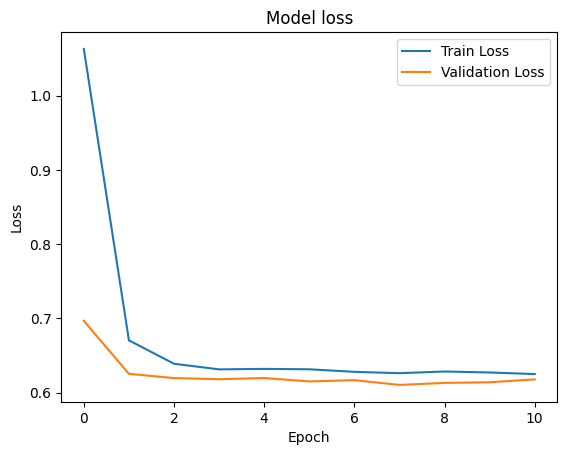

In [9]:
#모델 컴파일
model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
              loss='binary_crossentropy',  #이진 분류에 적합한 손실 함수
              metrics=['accuracy'])
#조기멈춤 도입
early_stopping = EarlyStopping(monitor='val_loss', #accuracy
                               patience=3,           #3번의 에폭 동안 개선이 없으면 중단
                               restore_best_weights=True)  #중단된 지점에서 최적의 가중치로 복원

#모델 학습
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=1,
    callbacks=[early_stopping]  # EarlyStopping 콜백 추가
)

#학습 과정 시각화
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

### 모델 저장

In [161]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb6 (Functional)     │ (None, 17, 17, 2304)   │    40,960,143 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2304)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,321,490 (165.26 MB)

 Trainable params: 6,683,793 (25.50 MB)

 Non-trainable params: 36,637,695 (139.76 MB)

 Optimizer params: 2 (12.00 B)

In [10]:
#모델 저장
model.save("model/model_v2.h5")

In [12]:
# # 모델 로드
# from tensorflow.keras.models import load_model

# model_path = "model/model_v6.h5"
# model = load_model(model_path)

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.trainable = False  # 모델을 평가 모드로 전환

#모델 평가: validation dataset에 대한 정확도 계산
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

#예측 및 실제 레이블을 추출하여 Confusion Matrix 계산
y_true = []
y_pred = []

#validation dataset에 대해 예측 수행
for images, labels in val_dataset:
    predictions = model.predict(images, batch_size=4, verbose=0)#로그 출력 생략verbose=0
    print(predictions)
    y_true.extend(labels)  #실제 레이블
    y_pred.extend(np.round(predictions).astype(int))  #예측 레이블 (0 또는 1로 변환)

#Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

#Confusion Matrix 시각화
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CONFIGURATION["CLASS_NAMES"], yticklabels=CONFIGURATION["CLASS_NAMES"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Confusion Matrix 출력
print("Confusion Matrix:")
print(cm)

 591/2199 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.8927 - loss: 0.4256

/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2199/2199 ━━━━━━━━━━━━━━━━━━━━ 48s 22ms/step - accuracy: 0.7922 - loss: 0.5063
Validation Accuracy: 68.85%
[[0.27773878]]
[[0.3094828]]
[[0.3009565]]
[[0.43508276]]
[[0.28073093]]
[[0.30745646]]
[[0.29773855]]
[[0.52349555]]
[[0.49016538]]
[[0.26853156]]
[[0.37677735]]
[[0.7025868]]
[[0.2995064]]
[[0.31534857]]
[[0.26656035]]
[[0.28475776]]
[[0.2979376]]
[[0.3426775]]
[[0.27912802]]
[[0.29004407]]
[[0.575312]]
[[0.29635182]]
[[0.51488686]]
[[0.26360312]]
[[0.31976092]]
[[0.48560506]]
[[0.26292673]]
[[0.19777253]]
[[0.3510154]]
[[0.2902288]]
[[0.30523688]]
[[0.3648185]]
[[0.29025778]]
[[0.31022343]]
[[0.3248262]]
[[0.32761055]]
[[0.29017648]]
[[0.5850602]]
[[0.28982818]]
[[0.22915709]]
[[0.26905832]]
[[0.345247]]
[[0.33322614]]
[[0.3019861]]
[[0.2999452]]
[[0.2589197]]
[[0.28743377]]
[[0.2809767]]
[[0.66522247]]
[[0.2929272]]
[[0.42266643]]
[[0.2808773]]
[[0.28778914]]
[[0.16359006]]
[[0.34981352]]
[[0.26498157]]
[[0.41174266]]
[[0.23810515]]
[[0.30382094]]
[[0.6363994]]
[[0.29030332]]


KeyboardInterrupt: 

## 자체 데이터셋에 대하여 테스트

### 데이터셋 준비

In [23]:
# from PIL import Image
# import os

# MAX_PIXELS = 178956970  # 허용되는 최대 픽셀 크기 (Pillow 기본값)
# VALID_EXTENSIONS = {".jpg", ".jpeg", ".png"}
# def remove_invalid_images(directory):
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             if not any(file.lower().endswith(ext) for ext in VALID_EXTENSIONS):
#                 continue  # 유효한 확장자가 아니면 건너뜀
#             try:
#                 img = Image.open(file_path)
#                 img.verify()  # 손상 여부 확인
#                 if img.size[0] * img.size[1] > MAX_PIXELS:
#                     print(f"Removing oversized image: {file_path}")
#                     os.remove(file_path)
#             except (IOError, SyntaxError, Image.DecompressionBombError):
#                 print(f"Removing invalid image: {file_path}")
#                 os.remove(file_path)

# remove_invalid_images(fake_dir)
# remove_invalid_images(real_dir)

### 평가 수행

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# 데이터셋 경로
dataset_dir = "data/gen_without_envir"
fake_dir = "data/gen_without_envir/fake"
real_dir = "data/gen_without_envir/real"

In [14]:
fake_count = len(os.listdir(fake_dir)) if os.path.exists(fake_dir) else 0
real_count = len(os.listdir(real_dir)) if os.path.exists(real_dir) else 0

print(f"Fake: {fake_count}, Real: {real_count}")

Fake: 270, Real: 133


In [ ]:
# # 모델 로드
# model_path = "model/model_v2.h5"
# model = load_model(model_path, compile=True)

Found 398 images belonging to 2 classes.


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step
[[0.2593884 ]
 [0.2643706 ]
 [0.2597748 ]
 [0.25106254]
 [0.2778706 ]
 [0.29190007]
 [0.26488826]
 [0.23494296]
 [0.25624833]
 [0.26523662]
 [0.2617455 ]
 [0.26261187]
 [0.26047927]
 [0.25210288]
 [0.29454696]
 [0.28050372]
 [0.23876823]
 [0.24714874]
 [0.31030414]
 [0.28390372]
 [0.27981827]
 [0.2704158 ]
 [0.28469902]
 [0.20031196]
 [0.2581672 ]
 [0.2386112 ]
 [0.376414  ]
 [0.28817987]
 [0.26591226]
 [0.30923414]
 [0.2232232 ]
 [0.38425994]
 [0.65312195]
 [0.19212563]
 [0.3053092 ]
 [0.2909891 ]
 [0.2449692 ]
 [0.34326774]
 [0.286256  ]
 [0.19564396]
 [0.25067174]
 [0.20673501]
 [0.06632179]
 [0.22194734]
 [0.19699268]
 [0.36239162]
 [0.43503547]
 [0.29877034]
 [0.2870084 ]
 [0.48566568]
 [0.34616795]
 [0.30168173]
 [0.26425198]
 [0.27362022]
 [0.2782891 ]
 [0.30636704]
 [0.20246874]
 [0.49845448]
 [0.27431574]
 [0.26220053]
 [0.19902357]
 [0.2835689 ]
 [0.21158546]
 [0.24792096]
 [0.31617156]
 [0.6594473 ]
 [0.64335144]
 [0.2579614 ]
 [0.

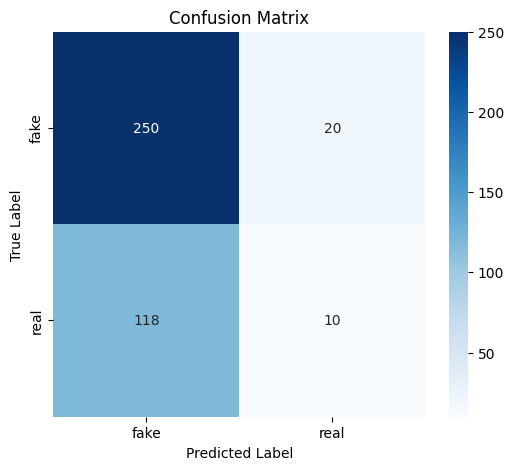


Classification Report:
              precision    recall  f1-score   support

        fake       0.68      0.93      0.78       270
        real       0.33      0.08      0.13       128

    accuracy                           0.65       398
   macro avg       0.51      0.50      0.46       398
weighted avg       0.57      0.65      0.57       398



In [15]:
# 이미지 크기 및 배치 사이즈 설정
img_size = (528, 528)  # EfficientNetB6의 입력 크기에 맞게 변경 가능
batch_size = 4

# 데이터 로더 설정 (test용)
datagen = ImageDataGenerator(rescale=1./255)


test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",  # 이진 분류 (fake vs real)
    shuffle= False
)

# 실제 라벨 가져오기
y_true = test_generator.classes  # 0: fake, 1: real
#print(y_true)
class_names = list(test_generator.class_indices.keys())
#print(class_names) #['fake', 'real']
#print(test_generator.class_indices)


# 예측 수행 (전체 데이터에 대해 예측)
y_pred_probs = model.predict(test_generator)  
print(y_pred_probs)
# 이진 분류 (0.5 이상이면 1, 아니면 0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# 크기 확인
print(f"y_true length: {len(y_true)}")
print(f"y_pred length: {len(y_pred)}")

# 데이터 개수가 맞지 않으면 맞춰줌
min_len = min(len(y_true), len(y_pred))
y_true, y_pred = y_true[:min_len], y_pred[:min_len]

# 정확도 출력
accuracy = np.mean(y_pred == y_true)
print(f"Model Accuracy: {accuracy:.4f}")

# Confusion Matrix 생성
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 분류 보고서 출력
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



## 자체 환경 데이터셋 추가 후, 테스트

### 자체 데이터셋 준비

In [89]:
# import os
# import unicodedata
# from PIL import Image

# # 이미지 경로 설정
# dataset_dir = "data/generated_dataset"
# fake_dir = os.path.join(dataset_dir, "fake")

# # 파일명 정리 + 변환 함수
# def clean_and_convert_images(directory):
#     for filename in os.listdir(directory):
#         # 유니코드 정규화 (한글 깨짐 방지)
#         normalized_filename = unicodedata.normalize("NFC", filename)
#         new_filename = normalized_filename  # 기본 파일명 설정

#         # "의 사본" 삭제
#         if "의 사본" in new_filename:
#             new_filename = new_filename.replace("의 사본", "").strip()

#         # 중복 확장자 제거 (예: .webp.webp → .webp)
#         root, ext = os.path.splitext(new_filename)
#         if root.endswith(ext):
#             new_filename = root

#         old_path = os.path.join(directory, filename)
#         new_path = os.path.join(directory, new_filename)

#         # 파일명이 변경되었을 경우만 수정
#         if filename != new_filename:
#             os.rename(old_path, new_path)
#             print(f"Renamed: {filename} -> {new_filename}")
#             old_path = new_path  # 변경된 파일명을 기반으로 다시 설정

#         # 확장자가 .webp인 경우 .png로 변환
#         if new_filename.endswith(".webp"):
#             png_filename = new_filename.replace(".webp", ".png")
#             png_path = os.path.join(directory, png_filename)

#             with Image.open(old_path) as img:
#                 img.save(png_path, "PNG")  # PNG로 저장

#             os.remove(old_path)  # 원본 .webp 파일 삭제
#             print(f"Converted: {new_filename} -> {png_filename}")

# # fake 디렉토리에서만 실행
# clean_and_convert_images(fake_dir)

# print("📂 fake 디렉토리 파일 정리 및 변환 완료! ✅")


In [90]:
# import os
# from PIL import Image

# # 이미지 경로 설정
# dataset_dir = "data/generated_dataset"
# fake_dir = os.path.join(dataset_dir, "fake")
# real_dir = os.path.join(dataset_dir, "real")

# # 변환 함수
# def convert_webp_to_jpeg(directory):
#     for filename in os.listdir(directory):
#         if filename.endswith(".webp"):
#             webp_path = os.path.join(directory, filename)
#             jpeg_path = os.path.join(directory, filename.replace(".webp", ".jpeg"))

#             # 이미지 변환
#             with Image.open(webp_path) as img:
#                 img = img.convert("RGB")  # RGB 모드로 변환
#                 img.save(jpeg_path, "JPEG", quality=95)  # JPEG로 저장

#             # 원본 webp 삭제
#             os.remove(webp_path)
#             print(f"Converted and deleted: {webp_path}")

# # 각 디렉토리에서 변환 실행
# convert_webp_to_jpeg(fake_dir)
# convert_webp_to_jpeg(real_dir)

# print("변환 완료!")


In [16]:
import os

dataset_dir = "data/generated_dataset/labeled"
fake_dir = os.path.join(dataset_dir, "fake")
real_dir = os.path.join(dataset_dir, "real")

fake_count = len(os.listdir(fake_dir)) if os.path.exists(fake_dir) else 0
real_count = len(os.listdir(real_dir)) if os.path.exists(real_dir) else 0

print(f"Fake: {fake_count}, Real: {real_count}")


Fake: 350, Real: 175


In [148]:
# from PIL import Image
# import os

# MAX_PIXELS = 178956970  # 허용되는 최대 픽셀 크기 (Pillow 기본값)
# VALID_EXTENSIONS = {".jpg", ".jpeg", ".png"}
# def remove_invalid_images(directory):
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             if not any(file.lower().endswith(ext) for ext in VALID_EXTENSIONS):
#                 continue  # 유효한 확장자가 아니면 건너뜀
#             try:
#                 img = Image.open(file_path)
#                 img.verify()  # 손상 여부 확인
#                 if img.size[0] * img.size[1] > MAX_PIXELS:
#                     print(f"Removing oversized image: {file_path}")
#                     os.remove(file_path)
#             except (IOError, SyntaxError, Image.DecompressionBombError):
#                 print(f"Removing invalid image: {file_path}")
#                 os.remove(file_path)

# remove_invalid_images(fake_dir)
# remove_invalid_images(real_dir)

### 자체데이터 평가 수행

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# 데이터셋 경로
dataset_dir = "data/generated_dataset/labeled"
fake_dir = "data/generated_dataset/labeled/fake"
real_dir = "data/generated_dataset/labeled/real"

In [18]:
fake_count = len(os.listdir(fake_dir)) if os.path.exists(fake_dir) else 0
real_count = len(os.listdir(real_dir)) if os.path.exists(real_dir) else 0

print(f"Fake: {fake_count}, Real: {real_count}")

Fake: 350, Real: 175


In [ ]:
# # 모델 로드
# model_path = "model/model_v6.h5"
# model = load_model(model_path)

Found 520 images belonging to 2 classes.


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step
[[0.24510933]
 [0.30851737]
 [0.24880335]
 [0.28225836]
 [0.27727997]
 [0.2559583 ]
 [0.24026994]
 [0.28750908]
 [0.27064902]
 [0.27932665]
 [0.23816417]
 [0.28327972]
 [0.27818957]
 [0.28004882]
 [0.3046253 ]
 [0.32197928]
 [0.31922776]
 [0.30339074]
 [0.262812  ]
 [0.5832473 ]
 [0.32194248]
 [0.19743194]
 [0.318962  ]
 [0.32482314]
 [0.25858545]
 [0.2620967 ]
 [0.30546585]
 [0.2997366 ]
 [0.25235435]
 [0.29171047]
 [0.2593884 ]
 [0.2643706 ]
 [0.2597748 ]
 [0.25106254]
 [0.37617284]
 [0.39709038]
 [0.29719383]
 [0.32612544]
 [0.32510528]
 [0.29193848]
 [0.31106588]
 [0.2832211 ]
 [0.6064467 ]
 [0.6781459 ]
 [0.3297688 ]
 [0.3160876 ]
 [0.28052303]
 [0.3144583 ]
 [0.29578042]
 [0.31269708]
 [0.29191172]
 [0.3027934 ]
 [0.3156464 ]
 [0.2808424 ]
 [0.2569892 ]
 [0.29621342]
 [0.28518537]
 [0.32821536]
 [0.22668421]
 [0.36623448]
 [0.26185223]
 [0.22221978]
 [0.33597544]
 [0.28912756]
 [0.2778706 ]
 [0.29190007]
 [0.26488826]
 [0.23494296]
 [0.25

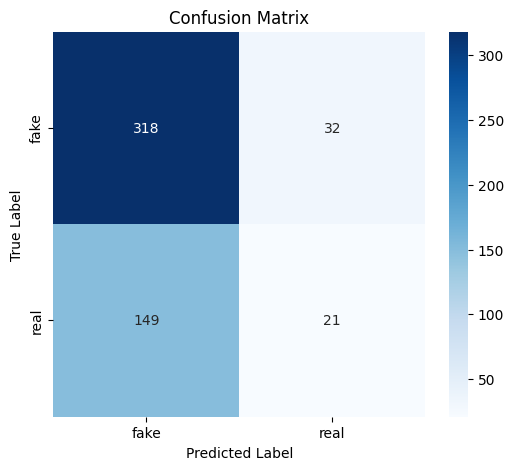


Classification Report:
              precision    recall  f1-score   support

        fake       0.68      0.91      0.78       350
        real       0.40      0.12      0.19       170

    accuracy                           0.65       520
   macro avg       0.54      0.52      0.48       520
weighted avg       0.59      0.65      0.59       520



In [19]:
# 이미지 크기 및 배치 사이즈 설정
img_size = (528, 528)  # EfficientNetB6의 입력 크기에 맞게 변경 가능
batch_size = 4

# 데이터 로더 설정 (test용)
datagen = ImageDataGenerator(rescale=1./255)


test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",  # 이진 분류 (fake vs real)
    shuffle= False
)

# 실제 라벨 가져오기
y_true = test_generator.classes  # 0: fake, 1: real
#print(y_true)
class_names = list(test_generator.class_indices.keys())
#print(class_names) #['fake', 'real']
#print(test_generator.class_indices)

# 예측 수행
y_pred_probs = model.predict(test_generator, steps=test_generator.samples // batch_size)  # 확률값 출력
print(y_pred_probs)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # 0.5 이상이면 1(real), 아니면 0(fake)

# 정확도 출력
accuracy = np.mean(y_pred == y_true)
print(f"Model Accuracy: {accuracy:.4f}")

# Confusion Matrix 생성
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 분류 보고서 출력
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## 저장된 모델 로딩 -> 자체이미지 데이터셋에서 학습 후 이진분류

In [37]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [39]:
train_dir = "data/generated_dataset/train_new"
test_dir = "data/generated_dataset/test_new"

### train, test 데이터셋 준비

In [ ]:
# # 데이터 경로 (가정: images 폴더에 fake와 real 이미지들이 있음)
# dataset_dir = "data/generated_dataset"
# fake_dir = os.path.join(dataset_dir, "fake")
# real_dir = os.path.join(dataset_dir, "real")

# # Train-Test Split을 위한 디렉토리 생성
# train_dir = "data/generated_dataset/train_new"
# test_dir = "data/generated_dataset/test_new"
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# train_fake_dir = os.path.join(train_dir, "fake")
# test_fake_dir = os.path.join(test_dir, "fake")
# train_real_dir = os.path.join(train_dir, "real")
# test_real_dir = os.path.join(test_dir, "real")

# os.makedirs(train_fake_dir, exist_ok=True)
# os.makedirs(test_fake_dir, exist_ok=True)
# os.makedirs(train_real_dir, exist_ok=True)
# os.makedirs(test_real_dir, exist_ok=True)

# # 이미지 파일 리스트 가져오기
# fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]
# real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]

# # train-test split (80% train, 20% test)
# fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=42)
# real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=42)

# # 파일 이동
# for file in fake_train:
#     shutil.copy(file, train_fake_dir)
# for file in fake_test:
#     shutil.copy(file, test_fake_dir)
# for file in real_train:
#     shutil.copy(file, train_real_dir)
# for file in real_test:
#     shutil.copy(file, test_real_dir)

# print("데이터셋 분할 완료!")


데이터셋 분할 완료!


In [ ]:
# from PIL import Image
# import os

# MAX_PIXELS = 178956970  # 허용되는 최대 픽셀 크기 (Pillow 기본값)
# VALID_EXTENSIONS = {".jpg", ".jpeg", ".png"}
# def remove_invalid_images(directory):
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             if not any(file.lower().endswith(ext) for ext in VALID_EXTENSIONS):
#                 continue  # 유효한 확장자가 아니면 건너뜀
#             try:
#                 img = Image.open(file_path)
#                 img.verify()  # 손상 여부 확인
#                 if img.size[0] * img.size[1] > MAX_PIXELS:
#                     print(f"Removing oversized image: {file_path}")
#                     os.remove(file_path)
#             except (IOError, SyntaxError, Image.DecompressionBombError):
#                 print(f"Removing invalid image: {file_path}")
#                 os.remove(file_path)

# remove_invalid_images(train_dir)
# remove_invalid_images(test_dir)

In [42]:
import os

train_fake_dir = os.path.join(train_dir, "fake")
train_real_dir = os.path.join(train_dir, "real")
test_fake_dir = os.path.join(test_dir, "fake")
test_real_dir = os.path.join(test_dir, "real")

train_fake_count = len(os.listdir(train_fake_dir)) if os.path.exists(train_fake_dir) else 0
train_real_count = len(os.listdir(train_real_dir)) if os.path.exists(train_real_dir) else 0
test_fake_count = len(os.listdir(test_fake_dir)) if os.path.exists(test_fake_dir) else 0
test_real_count = len(os.listdir(test_real_dir)) if os.path.exists(test_real_dir) else 0

print(train_fake_count,train_real_count,test_fake_count,test_real_count )
print(f"Fake: {train_fake_count + test_fake_count}, Real: {train_real_count + test_real_count}")


280 140 70 35
Fake: 350, Real: 175


### 학습

In [43]:
#저장된 EfficientNetB6 모델 로드
model_path = "model/model_v3.h5"
model = load_model(model_path)

In [44]:
#하이퍼파라미터 설정
CONFIGURATION = {
    "BATCH_SIZE": 4,
    "IM_SIZE": 528,  # EfficientNetB6의 입력 크기
    "LEARNING_RATE": 1e-4,
    "N_EPOCHS": 5,
    "DROPOUT_RATE": 0.2,
    "REGULARIZATION_RATE": 0.001,
    "N_DENSE_1": 1024,
    "CLASS_NAMES": ["fake", "real"]
}

n = 1
for layer in model.layers[:-n]:
    layer.trainable = False
for layer in model.layers[-n:]:
    layer.trainable = True

Found 415 images belonging to 2 classes.
Found 105 images belonging to 2 classes.
Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 90s 519ms/step - accuracy: 0.5630 - loss: 0.6904 - val_accuracy: 0.6667 - val_loss: 0.6712
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.5132 - loss: 0.7032 - val_accuracy: 0.6667 - val_loss: 0.6660
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - accuracy: 0.5862 - loss: 0.6741 - val_accuracy: 0.6667 - val_loss: 0.6611
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - accuracy: 0.6440 - loss: 0.6676 - val_accuracy: 0.6667 - val_loss: 0.6582
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.5711 - loss: 0.6904 - val_accuracy: 0.6667 - val_loss: 0.6547


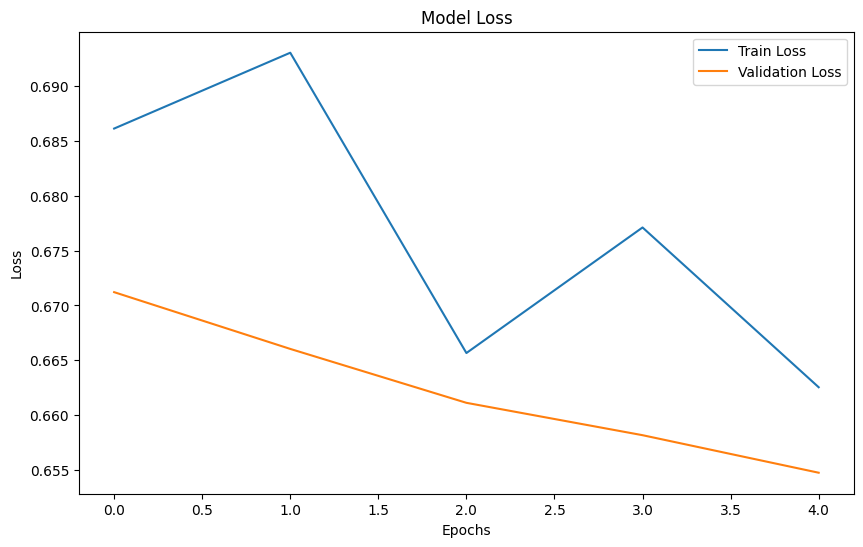

In [46]:
#데이터 증강 및 로드
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    batch_size=CONFIGURATION["BATCH_SIZE"],
    class_mode='binary'
)
val_dataset = val_datagen.flow_from_directory(
    test_dir,
    target_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    batch_size=CONFIGURATION["BATCH_SIZE"],
    class_mode='binary',
    shuffle=False,
    seed = 99
)

#모델 컴파일
model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

#모델 학습
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    callbacks=[early_stopping],
    verbose=1
)

#학습 과정 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#모델 저장}|
model.save("/content/drive/MyDrive/Generative_AI/model/final_model_v1.keras")

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 모델 평가: Validation 데이터셋에 대한 정확도 계산
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# 예측 및 실제 레이블 추출
y_true = []
y_pred = []

# Validation 데이터셋에서 예측 수행
for images, labels in val_dataset:
    predictions = model.predict(images, verbose=0)  # 로그 출력 생략
    y_true.extend(labels)  # 실제 레이블
    y_pred.extend(np.round(predictions).flatten())  # 예측 레이블 (0 또는 1로 변환)

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CONFIGURATION["CLASS_NAMES"],
    yticklabels=CONFIGURATION["CLASS_NAMES"],
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Confusion Matrix 출력
print("Confusion Matrix:")
print(cm)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9141 - loss: 0.5954
Validation Accuracy: 66.67%
